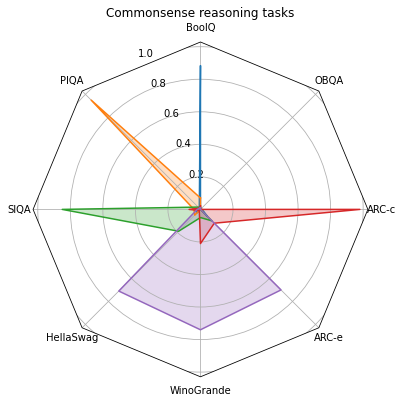

In [26]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


data = [['BoolQ', 'PIQA', 'SIQA', 'HellaSwag', 'WinoGrande', 'ARC-e', 'ARC-c', 'OBQA'],
        ('Commonsense reasoning tasks', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00]])]

N = len(data[0])
theta = radar_factory(N, frame='polygon')

spoke_labels = data.pop(0)
title, case_data = data[0]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

# ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title(title,  position=(0.5, 1.1), ha='center')

for d in case_data:
    line = ax.plot(theta, d)
    ax.fill(theta, d,  alpha=0.25)
ax.set_varlabels(spoke_labels)

plt.show()

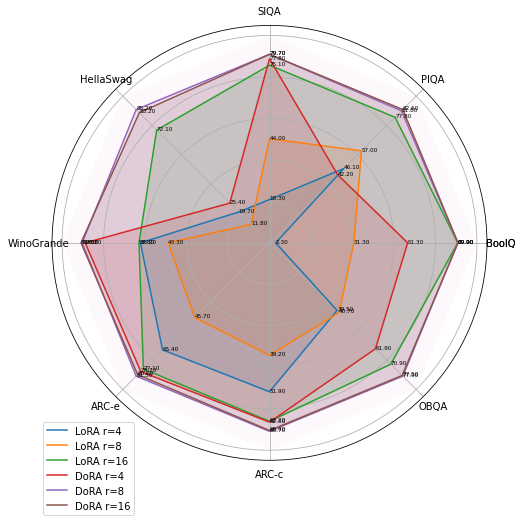

In [58]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def spider(df, *, id_column, title=None, max_values=None, padding=1.25):
    categories = df.dtypes[(df.dtypes == 'float') | (df.dtypes == 'int')].index.tolist()
    data = df[categories].to_dict(orient='list')
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding*max(value) for key, value in data.items()}
        
    normalized_data = {key: np.array(value) / max_values[key] for key, value in data.items()}
    num_vars = len(data.keys())
    tiks = list(data.keys())
    tiks += tiks[:1]
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, model_name in enumerate(ids):
        values = [normalized_data[key][i] for key in data.keys()]
        actual_values = [data[key][i] for key in data.keys()]
        values += values[:1]  # Close the plot for a better look
        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.15)
        for _x, _y, t in zip(angles, values, actual_values):
            t = f'{t:.2f}' if isinstance(t, float) else str(t)
            ax.text(_x, _y, t, size='xx-small')
            
    ax.fill(angles, np.ones(num_vars + 1), alpha=0.05)
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(tiks)
    ax.legend(loc='upper right', bbox_to_anchor=(0.2, 0.1))
    if title is not None: plt.suptitle(title)
    plt.savefig('rank_sensitiviy.pdf', format='pdf')
    # plt.show()
    
radar = spider

spider(
        pd.DataFrame({
        'x': ['LoRA r=4','LoRA r=8','LoRA r=16', 'DoRA r=4','DoRA r=8','DoRA r=16',],
        'BoolQ': [2.3, 31.3, 69.9, 51.3, 69.9, 70.0],
        'PIQA':  [46.1, 57.0, 77.8, 42.2, 81.8, 82.6],
        'SIQA':  [18.3, 44.0, 75.1, 77.8, 79.7, 79.7],
        'HellaSwag': [19.7, 11.8, 72.1, 25.4, 85.2, 83.2],
        'WinoGrande': [ 55.2, 43.3, 55.8, 78.8, 80.1, 80.6],
        'ARC-e': [ 65.4, 45.7, 77.1, 78.7, 81.5, 80.6],
        'ARC-c': [ 51.9, 39.2, 62.2, 62.5, 65.7, 65.4],
        'OBQA':  [ 39.5, 40.7, 70.9, 61.9, 77.9, 77.5]
    }),
    id_column='x',
    padding=1.1
)
